### Dependencies
- keras - obviously
- h5py - for model checkpointing
- keras-tqdm - because my [Jupyter notebooks freezes on the default Keras progbar](https://github.com/fchollet/keras/issues/4880). Also, it's awesome

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
'''Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
Reaches 98.6% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 3s on CPU (core i7).
'''

# compat
from __future__ import print_function

# python 
from imp import reload
from functools import reduce
import tarfile
import numpy as np
import re

# ML
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

from keras_tqdm import TQDMNotebookCallback

# local libs
import preprocess
import models
reload(preprocess)

Using TensorFlow backend.


<module 'preprocess' from 'C:\\Users\\HILA\\Google Drive\\code\\tf\\12 - chatbot Memory Network (bidirectional layer!!!)\\Siraj_Chatbot_Challenge-master\\preprocess.py'>

In [3]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz', origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise
tar = tarfile.open(path)

challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}
challenge_type = 'two_supporting_facts_10k' #'single_supporting_fact_10k'
challenge = challenges[challenge_type]

In [4]:
print('Extracting stories for the challenge:', challenge_type)
train_stories = preprocess.get_stories(tar.extractfile(challenge.format('train')))
test_stories = preprocess.get_stories(tar.extractfile(challenge.format('test')))

vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

Extracting stories for the challenge: two_supporting_facts_10k


C:\Users\HILA\Anaconda3\envs\py35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [5]:
vocab

['.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went']

In [6]:
train_stories[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.',
  'Mary',
  'got',
  'the',
  'football',
  'there',
  '.',
  'John',
  'went',
  'to',
  'the',
  'kitchen',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'kitchen',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'garden',
  '.'],
 ['Where', 'is', 'the', 'football', '?'],
 'garden')

Our vocab is pretty simple, and consists of the adverb 'where', people, places, prepositions, verbs, objects, definite article 'the', and two punctuation marks.

Our single adverb:  ['Where']

People: ['Daniel', 'John', 'Mary', 'Sandra']

Places: ['bathroom', 'bedroom', 'garden', 'hallway','kitchen','office']

Prepositions: ['back', 'to'] 

Verbs: ['is', 'journeyed', 'moved', 'travelled', 'went']
 
Articles: ['the']
 
Punctuanion: ['.', '?',]

In [6]:
# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_to_word = {value: key for (key, value) in word_idx.items()} # reverse lookup
idx_to_word.update({0: '~'})

-
Vocab size: 36 unique words
Story max length: 552 words
Query max length: 5 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'Sandra', 'journeyed', 'to', 'the', 'bedroom', '.', 'Mary', 'got', 'the', 'football', 'there', '.', 'John', 'went', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'kitchen', '.', 'Mary', 'went', 'back', 'to', 'the', 'garden', '.'], ['Where', 'is', 'the', 'football', '?'], 'garden')
-
Vectorizing the word sequences...


In [7]:
reload(preprocess)
ve = preprocess.BabiVectorizer()

inputs_train, queries_train, answers_train = ve.vectorize_all('train')

inputs_test, queries_test, answers_test = ve.vectorize_all('test')


Loading: {}qa1_single-supporting-fact_{}.txt


C:\Users\HILA\Anaconda3\envs\py35\lib\re.py:203: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [8]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')

-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 68)
inputs_test shape: (1000, 68)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-


In [9]:

class DeepMemNet:
    def __init__(self, vocab_size=22, story_maxlen=68, query_maxlen=4):
        # placeholders
        input_sequence = Input((story_maxlen,))
        question = Input((query_maxlen,))

        # encoders
        # embed the input sequence into a sequence of vectors
        input_encoder_m = Sequential()
        input_encoder_m.add(Embedding(input_dim=vocab_size,
                                      output_dim=64))
        input_encoder_m.add(Dropout(0.3))
        # output: (samples, story_maxlen, embedding_dim)

        # embed the input into a sequence of vectors of size query_maxlen
        input_encoder_c = Sequential()
        input_encoder_c.add(Embedding(input_dim=vocab_size,
                                      output_dim=query_maxlen))
        input_encoder_c.add(Dropout(0.3))
        # output: (samples, story_maxlen, query_maxlen)

        # embed the question into a sequence of vectors
        question_encoder = Sequential()
        question_encoder.add(Embedding(input_dim=vocab_size,
                                       output_dim=64,
                                       input_length=query_maxlen))
        question_encoder.add(Dropout(0.3))
        # output: (samples, query_maxlen, embedding_dim)

        # encode input sequence and questions (which are indices)
        # to sequences of dense vectors
        input_encoded_m = input_encoder_m(input_sequence)
        input_encoded_c = input_encoder_c(input_sequence)
        question_encoded = question_encoder(question)

        # compute a 'match' between the first input vector sequence
        # and the question vector sequence
        # shape: `(samples, story_maxlen, query_maxlen)`
        match = dot([input_encoded_m, question_encoded], axes=(2, 2))
        match = Activation('softmax')(match)

        # add the match matrix with the second input vector sequence
        response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
        response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

        # concatenate the match matrix with the question vector sequence
        answer = concatenate([response, question_encoded])

        # the original paper uses a matrix multiplication for this reduction step.
        # we choose to use a RNN instead.
        answer = LSTM(32)(answer)  # (samples, 32)

        # one regularization layer -- more would probably be needed.
        answer = Dropout(0.3)(answer)
        answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
        # we output a probability distribution over the vocabulary
        answer = Activation('softmax')(answer)

        # build the final model
        model = Model([input_sequence, question], answer)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        self.model = model


In [10]:
filepath = 'dmn{:02}.hdf5'.format(0)
checkpointer = ModelCheckpoint(monitor='val_acc', filepath=filepath, verbose=1, save_best_only=False)

In [12]:
dmn = DeepMemNet(vocab_size=ve.vocab_size, story_maxlen=ve.story_maxlen, query_maxlen=ve.query_maxlen)
dmn.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 68)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 4)             0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        multiple              1408        input_1[0][0]                    
____________________________________________________________________________________________________
sequential_3 (Sequential)        (None, 4, 64)         1408        input_2[0][0]                    
___________________________________________________________________________________________

In [13]:


# train
dmn.model.fit([inputs_train, queries_train], answers_train,
          batch_size=32,
          epochs=120,
          validation_data=([inputs_test, queries_test], answers_test),
             verbose=0, callbacks=[checkpointer, TQDMNotebookCallback()])

Epoch 00000: saving model to dmn00.hdf5


Epoch 00001: saving model to dmn00.hdf5


Epoch 00002: saving model to dmn00.hdf5


Epoch 00003: saving model to dmn00.hdf5


Epoch 00004: saving model to dmn00.hdf5


Epoch 00005: saving model to dmn00.hdf5


Epoch 00006: saving model to dmn00.hdf5


Epoch 00007: saving model to dmn00.hdf5


Epoch 00008: saving model to dmn00.hdf5


Epoch 00009: saving model to dmn00.hdf5


Epoch 00010: saving model to dmn00.hdf5


Epoch 00011: saving model to dmn00.hdf5


Epoch 00012: saving model to dmn00.hdf5


Epoch 00013: saving model to dmn00.hdf5


Epoch 00014: saving model to dmn00.hdf5


Epoch 00015: saving model to dmn00.hdf5


Epoch 00016: saving model to dmn00.hdf5


Epoch 00017: saving model to dmn00.hdf5


Epoch 00018: saving model to dmn00.hdf5


Epoch 00019: saving model to dmn00.hdf5


Epoch 00020: saving model to dmn00.hdf5


Epoch 00021: saving model to dmn00.hdf5


Epoch 00022: saving model to dmn00.hdf5


Epoch 00023: saving model to dmn00.hdf5


Epoch 00024: saving model to dmn00.hdf5


Epoch 00025: saving model to dmn00.hdf5


Epoch 00026: saving model to dmn00.hdf5


Epoch 00027: saving model to dmn00.hdf5


Epoch 00028: saving model to dmn00.hdf5


Epoch 00029: saving model to dmn00.hdf5


Epoch 00030: saving model to dmn00.hdf5


Epoch 00031: saving model to dmn00.hdf5


Epoch 00032: saving model to dmn00.hdf5


Epoch 00033: saving model to dmn00.hdf5


Epoch 00034: saving model to dmn00.hdf5


Epoch 00035: saving model to dmn00.hdf5


Epoch 00036: saving model to dmn00.hdf5


Epoch 00037: saving model to dmn00.hdf5


Epoch 00038: saving model to dmn00.hdf5


Epoch 00039: saving model to dmn00.hdf5


Epoch 00040: saving model to dmn00.hdf5


Epoch 00041: saving model to dmn00.hdf5


Epoch 00042: saving model to dmn00.hdf5


Epoch 00043: saving model to dmn00.hdf5


Epoch 00044: saving model to dmn00.hdf5


Epoch 00045: saving model to dmn00.hdf5


Epoch 00046: saving model to dmn00.hdf5


Epoch 00047: saving model to dmn00.hdf5


Epoch 00048: saving model to dmn00.hdf5


Epoch 00049: saving model to dmn00.hdf5


Epoch 00050: saving model to dmn00.hdf5


Epoch 00051: saving model to dmn00.hdf5


Epoch 00052: saving model to dmn00.hdf5


Epoch 00053: saving model to dmn00.hdf5


Epoch 00054: saving model to dmn00.hdf5


Epoch 00055: saving model to dmn00.hdf5


Epoch 00056: saving model to dmn00.hdf5


Epoch 00057: saving model to dmn00.hdf5


Epoch 00058: saving model to dmn00.hdf5


Epoch 00059: saving model to dmn00.hdf5


Epoch 00060: saving model to dmn00.hdf5


Epoch 00061: saving model to dmn00.hdf5


Epoch 00062: saving model to dmn00.hdf5


Epoch 00063: saving model to dmn00.hdf5


Epoch 00064: saving model to dmn00.hdf5


Epoch 00065: saving model to dmn00.hdf5


Epoch 00066: saving model to dmn00.hdf5


Epoch 00067: saving model to dmn00.hdf5


Epoch 00068: saving model to dmn00.hdf5


Epoch 00069: saving model to dmn00.hdf5


Epoch 00070: saving model to dmn00.hdf5


Epoch 00071: saving model to dmn00.hdf5


Epoch 00072: saving model to dmn00.hdf5


Epoch 00073: saving model to dmn00.hdf5


Epoch 00074: saving model to dmn00.hdf5


Epoch 00075: saving model to dmn00.hdf5


Epoch 00076: saving model to dmn00.hdf5


Epoch 00077: saving model to dmn00.hdf5


Epoch 00078: saving model to dmn00.hdf5


Epoch 00079: saving model to dmn00.hdf5


Epoch 00080: saving model to dmn00.hdf5


Epoch 00081: saving model to dmn00.hdf5


Epoch 00082: saving model to dmn00.hdf5


Epoch 00083: saving model to dmn00.hdf5


Epoch 00084: saving model to dmn00.hdf5


Epoch 00085: saving model to dmn00.hdf5


Epoch 00086: saving model to dmn00.hdf5


Epoch 00087: saving model to dmn00.hdf5


Epoch 00088: saving model to dmn00.hdf5


Epoch 00089: saving model to dmn00.hdf5


Epoch 00090: saving model to dmn00.hdf5


Epoch 00091: saving model to dmn00.hdf5


Epoch 00092: saving model to dmn00.hdf5


Epoch 00093: saving model to dmn00.hdf5


Epoch 00094: saving model to dmn00.hdf5


Epoch 00095: saving model to dmn00.hdf5


Epoch 00096: saving model to dmn00.hdf5


Epoch 00097: saving model to dmn00.hdf5


Epoch 00098: saving model to dmn00.hdf5


Epoch 00099: saving model to dmn00.hdf5


Epoch 00100: saving model to dmn00.hdf5


Epoch 00101: saving model to dmn00.hdf5


Epoch 00102: saving model to dmn00.hdf5


Epoch 00103: saving model to dmn00.hdf5


Epoch 00104: saving model to dmn00.hdf5


Epoch 00105: saving model to dmn00.hdf5


Epoch 00106: saving model to dmn00.hdf5


Epoch 00107: saving model to dmn00.hdf5


Epoch 00108: saving model to dmn00.hdf5


Epoch 00109: saving model to dmn00.hdf5


Epoch 00110: saving model to dmn00.hdf5


Epoch 00111: saving model to dmn00.hdf5


Epoch 00112: saving model to dmn00.hdf5


Epoch 00113: saving model to dmn00.hdf5


Epoch 00114: saving model to dmn00.hdf5


Epoch 00115: saving model to dmn00.hdf5


Epoch 00116: saving model to dmn00.hdf5


Epoch 00117: saving model to dmn00.hdf5


Epoch 00118: saving model to dmn00.hdf5


Epoch 00119: saving model to dmn00.hdf5



In [14]:
ans = dmn.model.predict([inputs_test, queries_test])

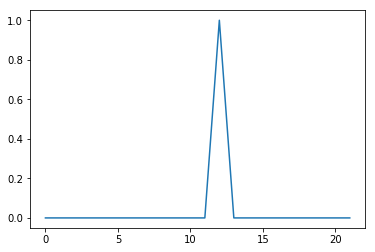

In [15]:
plt.plot(ans[0])

In [16]:
i = 0
sentence = ve.deindex_sentence(inputs_test[i])
print(sentence)

query = ve.deindex_sentence(queries_test[i])
print(query)

print(ve.devectorize_ans(ans[i]))

John travelled to the hallway.
Mary journeyed to the bathroom.
Where is John ?
('hallway', 0.99999988)


In [17]:
i = 1
sentence = ve.deindex_sentence(inputs_test[i])
print(sentence)

query = ve.deindex_sentence(queries_test[i])
print(query)

print(ve.devectorize_ans(ans[i]))

John travelled to the hallway.
Mary journeyed to the bathroom.
Daniel went back to the bathroom.
John moved to the bedroom.
Where is Mary ?
('bathroom', 0.99995363)
